## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [23]:
import string
import os
import numpy as np
import torch, torch.nn as nn
import random
from torch.autograd import Variable
import torch.nn.functional as F
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [24]:
if not os.path.exists('data.txt'):
    !wget https://raw.githubusercontent.com/AnastasiyaFokina/ML_study_public/master/data.txt

with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
    
##TEXT_START = 45
#TEXT_END = -368
#text = text[TEXT_START : TEXT_END]
#assert len(text) == 2616
len(text)

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


7088

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [25]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

#assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
##assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
#print('OK!')

### Data loading: "Евгений Онегин"


In [26]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines(
        
    )
    
text = [x.replace('\t\t', '') for x in text]

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [27]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [28]:
tokens = sorted(set(text))

In [29]:
len(tokens)

83

In [30]:
tokens

['\n',
 ' ',
 '!',
 '(',
 ')',
 ',',
 '-',
 '.',
 '5',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '[',
 ']',
 '^',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '«',
 '»',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 '–',
 '—',
 '’',
 '…',
 '€']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [31]:
# dict <index>:<char>
# Your great code here
idx_to_token = dict(zip(range(len(tokens)), tokens))
# dict <char>:<index>
# Your great code here
token_to_idx = dict(zip(tokens, range(len(tokens))))

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [32]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens, emb_size=90, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.fc = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.num_units)
        out = self.fc(out)
        return out, hidden
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(1, batch_size, self.num_units)).to(device)

In [33]:
def get_batches(arr, batch_size, seq_length):
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [34]:
def one_hot_encode(arr, n_labels):   
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    return one_hot

In [35]:
encoded = np.array([token_to_idx[ch] for ch in text])

In [36]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, 
          temperature=0.2, lstm=False):
    
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    val_idx = int(len(data)*(0.9))
    data, val_data = data[:val_idx], data[val_idx:]
    
    counter = 0
    n_chars = len(tokens)
    for e in range(epochs):
        h = net.initial_state(batch_size)
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            inputs, targets = inputs.to(device), targets.to(device)
            net.zero_grad()
            
            if lstm:
                h = tuple([each.data for each in h])
            else:
                h = h.detach()
                
            output, h = net(inputs, h)
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
        
            if counter % 100 == 0:
                # Get validation loss
                val_h = net.initial_state(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    if lstm:
                        val_h = tuple([each.data for each in val_h])
                    else:
                        val_h = val_h.detach()
                    
                    inputs, targets = x, y
                    inputs, targets = inputs.to(device), targets.to(device)

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                train_loss.append(loss.item())
                test_loss.append(np.mean(val_losses))

In [37]:
def predict(net, char, h=None, temperature=0.2, lstm=False):
        x = np.array([[token_to_idx[char]]])
        x = one_hot_encode(x, len(tokens))
        inputs = torch.from_numpy(x).to(device)
        
        if lstm:
            h = tuple([each.data for each in h])
        else:
            h = h.detach()
            
        out, h = net(inputs, h)
        
        p = F.softmax(out/temperature, dim=1).data
        p = p.cpu().numpy().squeeze()
        char = np.random.choice(len(tokens), p=p/p.sum())
        return idx_to_token[char], h

def sample(net, size, prime='the', temperature=0.2, lstm=False):
        
    net.to(device)
    net.eval()
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.initial_state(1)
    for ch in prime:
        char, h = predict(net, ch, h, temperature, lstm)

    chars.append(char)
    
    for ii in range(size):
        char, h = predict(net, chars[-1], h, temperature, lstm)
        chars.append(char)

    return ''.join(chars)

In [38]:
train_loss, test_loss = [], []
net = CharRNNLoop(len(tokens), rnn_num_units=256, emb_size=83).to(device)
train(net, encoded, epochs=200, batch_size=100, seq_length=100)

Epoch: 9/200... Step: 100... Loss: 3.1961... Val Loss: 3.2345
Epoch: 17/200... Step: 200... Loss: 2.7425... Val Loss: 2.8062
Epoch: 25/200... Step: 300... Loss: 2.5690... Val Loss: 2.6087
Epoch: 34/200... Step: 400... Loss: 2.4950... Val Loss: 2.5220
Epoch: 42/200... Step: 500... Loss: 2.3841... Val Loss: 2.4716
Epoch: 50/200... Step: 600... Loss: 2.3438... Val Loss: 2.4043
Epoch: 59/200... Step: 700... Loss: 2.2808... Val Loss: 2.3786
Epoch: 67/200... Step: 800... Loss: 2.1912... Val Loss: 2.3437
Epoch: 75/200... Step: 900... Loss: 2.2142... Val Loss: 2.3242
Epoch: 84/200... Step: 1000... Loss: 2.1642... Val Loss: 2.2969
Epoch: 92/200... Step: 1100... Loss: 2.0673... Val Loss: 2.2798
Epoch: 100/200... Step: 1200... Loss: 2.1076... Val Loss: 2.2641
Epoch: 109/200... Step: 1300... Loss: 2.0428... Val Loss: 2.2554
Epoch: 117/200... Step: 1400... Loss: 1.9545... Val Loss: 2.2544
Epoch: 125/200... Step: 1500... Loss: 1.9961... Val Loss: 2.2464
Epoch: 134/200... Step: 1600... Loss: 1.9250..

In [39]:
from matplotlib import pyplot as plt
def plot_train_process(train_loss, test_loss):
  fig, axes = plt.subplots(1, 1,figsize=(15,5))

  axes.set_title("Loss")
  axes.plot(train_loss, label='train')
  axes.plot(test_loss, label='test')
  axes.legend()

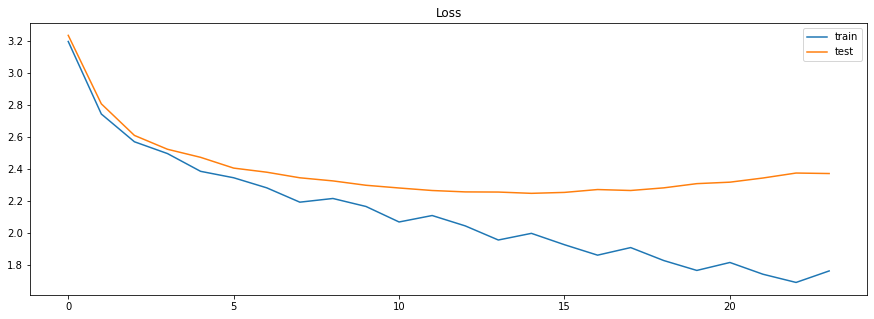

In [40]:
plot_train_process(train_loss, test_loss)

In [41]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

In [42]:
print(sample(net, 5000, prime='я'))

я, старина
и мог деветь на страшный дель
на стол не насленный подой
не мне скучал и подарить,
серей потом потом небен.



xx

коть, поэти в гостиной коне,
посто ле сторо не стеле
и все проводно постали
и мог де не заменали
но полно, не страстих проводит,
не старной не стани молодой,
слова после на столомой
тетел она после севсем
и старосеть де замледной
старина светские польмо
и вол подушить его нашел
не воста в горе не замета,
в сем сторо своей сонечно,
так небограз окомой.
татьяна с ней неж и там,
кладной наслетною слеза
весно уволкает собраний
своих соловой полной вест,
и воспостила сольстали сольно,
не подушный сол закорет.



xx

но вость онегин полегом,
он глубино слез постала
и следо бладостивить —
вот предках он стан он перед,
приледно страстит и постел
не стали сердце полем
не вос даше сердце грусти
она друженный потруком
седин прединевных доманной
под небоветь он уменал,
и всё ревному по вдруг,
он простовет не стари стали



xii

как на послешной сердце венной
они сердца, по 

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [43]:
# Your beautiful code here
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens, emb_size=90, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=2, dropout=0.5)
        self.fc = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.num_units)
        out = self.fc(out)
        return out, hidden
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return (Variable(torch.zeros(2, batch_size, self.num_units)).to(device),
                Variable(torch.zeros(2, batch_size, self.num_units)).to(device))

In [44]:
train_loss, test_loss = [], []
net = CharLSTMLoop(len(tokens), rnn_num_units=512,emb_size=83).to(device)
train(net, encoded, lstm=True, epochs=100, batch_size=100, seq_length=100)

Epoch: 9/100... Step: 100... Loss: 3.2126... Val Loss: 3.2534
Epoch: 17/100... Step: 200... Loss: 2.5631... Val Loss: 2.6474
Epoch: 25/100... Step: 300... Loss: 2.4345... Val Loss: 2.4749
Epoch: 34/100... Step: 400... Loss: 2.2504... Val Loss: 2.3283
Epoch: 42/100... Step: 500... Loss: 2.1092... Val Loss: 2.2318
Epoch: 50/100... Step: 600... Loss: 2.0545... Val Loss: 2.1592
Epoch: 59/100... Step: 700... Loss: 1.9097... Val Loss: 2.1153
Epoch: 67/100... Step: 800... Loss: 1.7689... Val Loss: 2.1096
Epoch: 75/100... Step: 900... Loss: 1.7438... Val Loss: 2.1071
Epoch: 84/100... Step: 1000... Loss: 1.5575... Val Loss: 2.1595
Epoch: 92/100... Step: 1100... Loss: 1.3966... Val Loss: 2.2192
Epoch: 100/100... Step: 1200... Loss: 1.3834... Val Loss: 2.2835


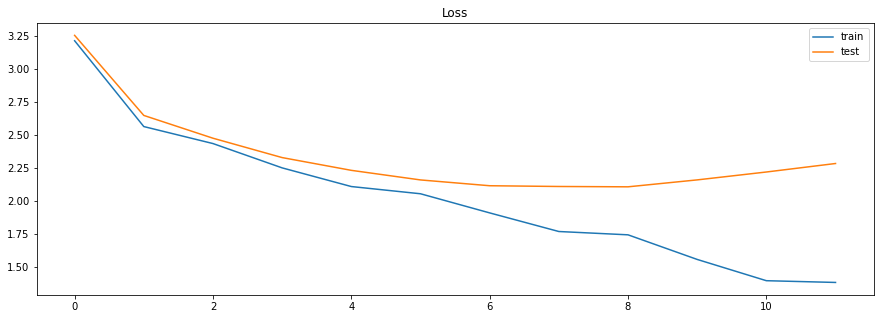

In [45]:
plot_train_process(train_loss, test_loss)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [46]:
# Text generation with different temperature values here
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('-----Current temp: {}------'.format(temp))
    print(sample(net, 500, prime='a', temperature=temp, lstm=True))

-----Current temp: 0.1------
al


xxxviii

и вот уж не всё верной души,
и всё то же, как меня списны,
кого нашел я был бы старон,
и всё в постелной простой своей
кареча старый и постеле
про столе старого в себя,
как будто было он серески,
и слово в денью в том и поэт
и после приятнову и странной
обиной старог на сталених,
и всё в конечно прикавленьем
не всё в конечно послененный,
всё то же сказал и бограна,
он постала на неварена
и в томне проставном подоснались,
она в последнем на старенных,
и страстный как по лушене
и татья
-----Current temp: 0.2------
ali

и всё благорода послуга
по скучам сумрачной порой
не стариных бедного сведанье
приводит с нимого всеманий,
в постенной полною подоснет.



xxxvii

«не доме с ним меня без собою,
скарастики молодок дума,
и простоворется на свете,
как будто было она всегодной,
и вот с посленной поковенье,
и всё то же, как быть, богодный,
и слеза в сам медтем на могом,
иль при разум и весель.
она в старом подамит и света
приводиш сердце в поли мне
по

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [47]:
# Saving and loading code here
torch.save(net.state_dict(), './model.pt')
loaded_model = CharLSTMLoop(len(tokens), rnn_num_units=512).to(device)
loaded_model.load_state_dict(torch.load('./model.pt'))
loaded_model.eval()
print(sample(loaded_model, 500, lstm=True))

RuntimeError: Error(s) in loading state_dict for CharLSTMLoop:
	size mismatch for rnn.weight_ih_l0: copying a param with shape torch.Size([2048, 83]) from checkpoint, the shape in current model is torch.Size([2048, 90]).

Не очень понятно, нужен ли отчет, но пусть будет. 

Решила взять Шекспира, скорее из желания работать с английским языком.

Очевидны преимущества LSTM как из сэмплов, так и из графиков.

Немного неочевдны итоги с экспериментов с температурой: мной отмечены рост разнообразия пунктуации с ростом температуры- появляются восклицательные знаки, двоеточия, ; Также появлятся попытки притяжательных прилагательных. Разнообразие слов оценить затрудняюсь.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)